![image.png](https://i.imgur.com/a3uAqnb.png)

In [1]:
#@title importing libraries
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

Note: We're using torch modules (datasets, dataloaders) to download dataset and easily make batches. The NN will be made in numpy and every step will be implemented ourselves

## Contents:

1. Transfer learning
2. Loading pretrained models from torch
3. Changing intermediate layers or last layers

In [41]:
# ------------------------------
#@title 1) DEFINE BASIC TRANSFORM (NO NORMALIZATION YET)
# ------------------------------
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [42]:
# ------------------------------
#@title 2) DOWNLOAD DATASET
# ------------------------------
train_dataset = datasets.OxfordIIITPet(
    root="./data",
    split="trainval",
    download=True,
    transform=basic_transform,
    target_types="category"
)

test_dataset = datasets.OxfordIIITPet(
    root="./data",
    split="test",
    download=True,
    transform=basic_transform,
    target_types="category"
)

In [43]:
# ------------------------------
#@title 3) SEE LABEL INFO
# ------------------------------
print("Number of training images:", len(train_dataset))
print("Number of test images:", len(test_dataset))
print("Number of classes:", len(train_dataset.classes))
print("Classes:", train_dataset.classes[:10], "...")  # print first few

Number of training images: 3680
Number of test images: 3669
Number of classes: 37
Classes: ['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British Shorthair'] ...


In [44]:
# ------------------------------
#@title 4) DATALOADER
# ------------------------------
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)


--- Image Properties ---
Type: <class 'torch.Tensor'>
Shape (C,H,W): torch.Size([3, 224, 224])
Dtype: torch.float32
Min pixel: 0.007843137718737125
Max pixel: 1.0
Label index: 0
Label name: Abyssinian


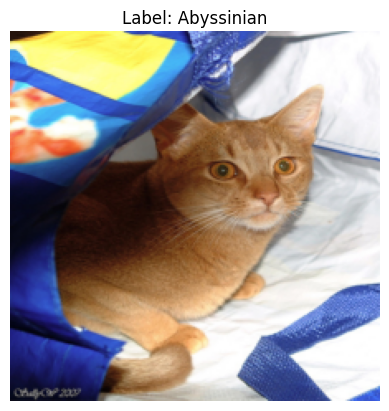

In [45]:
# ------------------------------
#@title 5) INSPECT ONE IMAGE
# ------------------------------
img, label = train_dataset[0]

print("\n--- Image Properties ---")
print("Type:", type(img))
print("Shape (C,H,W):", img.shape)
print("Dtype:", img.dtype)
print("Min pixel:", img.min().item())
print("Max pixel:", img.max().item())
print("Label index:", label)
print("Label name:", train_dataset.classes[label])

# Show image
plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
plt.title(f"Label: {train_dataset.classes[label]}")
plt.axis("off")
plt.show()

In [46]:
# ---------------------------------------------------
#@title 6) AUGMENTATION PIPELINE (COMMENT ON/OFF WHAT YOU NEED)
# ---------------------------------------------------
augment_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),

    # ------- GEOMETRIC AUGS -------
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation(degrees=30),
    # transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    # transforms.RandomAffine(degrees=20, shear=10),

    # ------- COLOR AUGS -------
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),

    # ------- NORMALIZATION -------
    # NOTE: Only enable after deciding!
    # transforms.Normalize(
    #     mean=[0.485, 0.456, 0.406],
    #     std=[0.229, 0.224, 0.225]
    # ),

    # ------- ADDING NOISE (manual example below instead)
    # AddGaussianNoise(std=.5),
])

train_dataset = datasets.OxfordIIITPet(
    root="./data",
    split="trainval",
    download=True,
    transform=augment_transform,
    target_types="category"
)

test_dataset = datasets.OxfordIIITPet(
    root="./data",
    split="test",
    download=True,
    transform=basic_transform,
    target_types="category"
)

img_aug, label_aug = train_dataset[1]
print(img_aug.shape)

torch.Size([3, 224, 224])


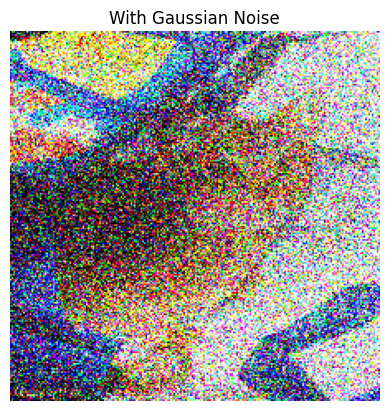

In [47]:
# ------------------------------
#@title OPTIONAL: ADD GAUSSIAN NOISE EXAMPLE
# ------------------------------
class AddGaussianNoise(object):
    def __init__(self, std=0.05):
        self.std = std

    def __call__(self, x):
        noise = torch.randn_like(x) * self.std
        x = x + noise
        return torch.clamp(x, 0, 1)

noisy_img = add_noise(img, noise_level=.5)

plt.imshow(np.transpose(noisy_img.numpy(), (1, 2, 0)))
plt.title("With Gaussian Noise")
plt.axis("off")
plt.show()


--- After Augmentation ---
Shape: torch.Size([3, 224, 224])
Min pixel: 0.039242640137672424
Max pixel: 0.785088300704956


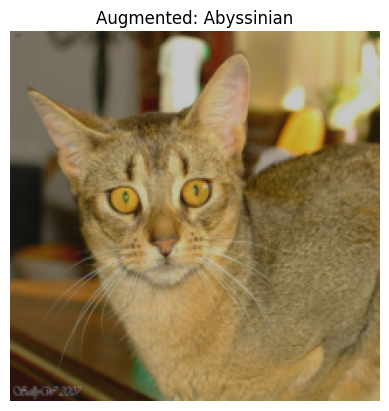

In [51]:
# ------------------------------
#@title 7) SHOW AUGMENTED IMAGE
# ------------------------------
img_aug, label_aug = train_dataset[2]

print("\n--- After Augmentation ---")
print("Shape:", img_aug.shape)
print("Min pixel:", img_aug.min().item())
print("Max pixel:", img_aug.max().item())

plt.imshow(np.transpose(img_aug.numpy(), (1, 2, 0)))
plt.title(f"Augmented: {train_dataset.classes[label_aug]}")
plt.axis("off")
plt.show()

In [52]:
# ------------------------------
#@title 8) DATA LOADERS
# ------------------------------
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,          # shuffle ONLY train
    num_workers=2,          # adjust depending on machine
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,         # NEVER shuffle test
    num_workers=2,
    pin_memory=True
)

print("Train batches:", len(train_loader))
print("Test  batches:", len(test_loader))

# ---- OPTIONAL: sanity check a batch ----
images, labels = next(iter(train_loader))

print("\nTrain batch:")
print("Images shape:", images.shape)   # [B, C, H, W]
print("Labels shape:", labels.shape)
print("Min pixel:", images.min().item())
print("Max pixel:", images.max().item())


Train batches: 115
Test  batches: 115

Train batch:
Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Min pixel: 0.0
Max pixel: 1.0


## Transfer Learning:

1. Load resnet 18 archeticture without the pretrained weights

2. evaluate before training

3. evaluate after training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# 1) LOAD RESNET18 (NO PRETRAIN)
# -----------------------------
model = models.resnet18(weights=None)
model

In [53]:
# change last layer (fc)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 37)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


Using device: cuda


In [54]:
def evaluate(loader, desc="Eval"):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total * 100
    print(f"{desc} Accuracy: {acc:.2f}%")
    return acc

In [55]:
print("Before training:")
evaluate(test_loader, "Test")

Before training:
Test Accuracy: 2.83%


2.8345598255655493

## The main training loop



In [57]:
def train_one_epoch():
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Train Loss: {avg_loss:.4f}")
    return avg_loss

In [58]:
EPOCHS = 5   # change if you want more
losses = []
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    avg_loss = train_one_epoch()
    losses.append(avg_loss)
    evaluate(test_loader, "Test")


Epoch 1/5
Train Loss: 3.6246
Test Accuracy: 8.20%

Epoch 2/5
Train Loss: 3.3625
Test Accuracy: 7.63%

Epoch 3/5
Train Loss: 3.1947
Test Accuracy: 7.33%

Epoch 4/5
Train Loss: 3.0524
Test Accuracy: 11.01%

Epoch 5/5
Train Loss: 2.9119
Test Accuracy: 11.17%


Time of execution (5m 14s)

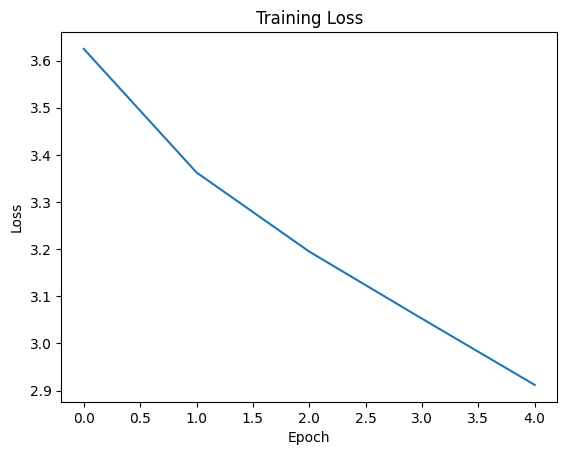

In [59]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

## Transfer Learning:

1. Load resnet 18 archeticture with the pretrained weights

2. evaluate before training

3. evaluate after training

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# -----------------------------
# 1) LOAD PRETRAINED RESNET18
# -----------------------------
weights = models.ResNet18_Weights.DEFAULT
model = models.resnet18(weights=weights)
model

Using: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 191MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [61]:
# -----------------------------
# 2) CHANGE FINAL LAYER
# -----------------------------
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 37)

model = model.to(device)

# -----------------------------
# 3) FREEZE ALL EXCEPT LAST LAYER
# -----------------------------
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():     # only classifier learns
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)


In [62]:
print("Before training (pretrained backbone, random classifier):")
evaluate(test_loader, "Test")

Before training (pretrained backbone, random classifier):
Test Accuracy: 1.66%


1.6625783592259473

### Training loop

In [63]:
%%time
EPOCHS = 5   # increase if you want

losses = []
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    avg_loss = train_one_epoch()
    losses.append(avg_loss)
    evaluate(test_loader, "Test")


Epoch 1/5
Train Loss: 2.0237
Test Accuracy: 79.23%

Epoch 2/5
Train Loss: 0.8396
Test Accuracy: 84.11%

Epoch 3/5
Train Loss: 0.5944
Test Accuracy: 83.86%

Epoch 4/5
Train Loss: 0.4922
Test Accuracy: 85.88%

Epoch 5/5
Train Loss: 0.4273
Test Accuracy: 86.21%
CPU times: user 30.4 s, sys: 6.23 s, total: 36.6 s
Wall time: 5min 4s


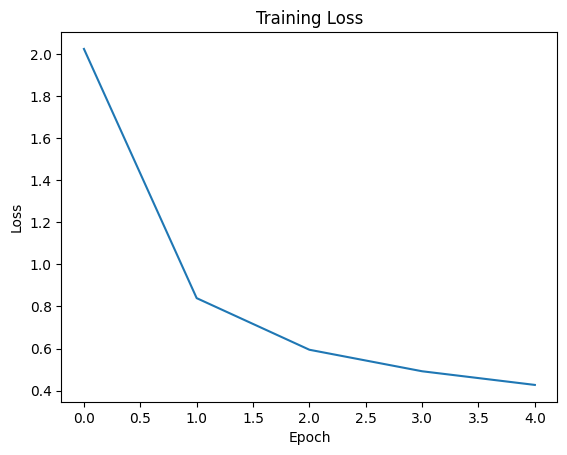

In [67]:
#@title plotting
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [ ]:
#@title model saving
torch.save(model.state_dict(), "resnet18_pets.pt")
print("Model weights saved!")

In [ ]:
#@title model loading
from torchvision import models
import torch.nn as nn

weights = models.ResNet18_Weights.DEFAULT
model = models.resnet18(weights=weights)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 37)

model.load_state_dict(torch.load("resnet18_pets.pt", map_location=device))
model.to(device)
model.eval()

## Tasks EfficientNet

In [ ]:
# ============================
# EfficientNet Transfer Learning TODO Template
# ============================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# ---------------------------
# DEVICE
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# ---------------------------
# TODO 1: LOAD EFFICIENTNET MODEL
# Hint: use models.efficientnet_b0 or b1/b2
# Hint: choose pretrained weights (similar to ResNet step)
# model = ...
# ---------------------------


# ---------------------------
# TODO 2: CHANGE FINAL LAYER TO 37 CLASSES
# Hint: EfficientNet uses model.classifier[1]
# Hint: find in_features then replace with Linear(in_features, 37)
# ---------------------------


# ---------------------------
# TODO 3: FREEZE BACKBONE
# Hint: turn off gradients for all layers except classifier
# for param in model.parameters():
#     ...
# ---------------------------


# ---------------------------
# TODO 4: SEND MODEL TO DEVICE
# model = ...
# ---------------------------


# ---------------------------
# TODO 5: DEFINE LOSS + OPTIMIZER
# Hint: CrossEntropyLoss
# Hint: optimizer should only train classifier parameters
# ---------------------------


# ---------------------------
# TODO 6: EVALUATION FUNCTION
# Hint: same evaluate() as ResNet version
# ---------------------------


# ---------------------------
# TODO 7: TRAIN LOOP
# Hint: same training loop as before
# Hint: remember to model.train() and model.eval()
# ---------------------------


# ---------------------------
# TODO 8: EVALUATE BEFORE TRAINING
# Hint: show improvement vs random classifier
# ---------------------------


# ---------------------------
# TODO 9: TRAIN FOR A FEW EPOCHS
# Hint: use small LR because pretrained backbone
# ---------------------------


# ---------------------------
# TODO 10: EVALUATE AFTER TRAINING
# Hint: compare accuracy jump
# ---------------------------


# ---------------------------
# OPTIONAL TODOs:
# - Unfreeze last few EfficientNet blocks and fine-tune
# - Add scheduler
# - Save model to .pt
# - Compare accuracy vs ResNet
# ---------------------------
